In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
appeals_df = pd.read_csv('../data/zoning_board_appeals_tracker.csv')
print(appeals_df.shape)
print(appeals_df.columns.to_list())
appeals_df.head()

(9043, 19)
['address', 'status', 'parent_apno', 'boa_apno', 'appeal_type', 'contact', 'submitted_date', 'received_date', 'hearing_date', 'ever_deferred', 'num_deferrals', 'final_decision_date', 'decision', 'closed_date', 'city', 'zip', 'ward', 'zoning_district', 'project_description']


,address,status,parent_apno,boa_apno,appeal_type,contact,submitted_date,received_date,hearing_date,ever_deferred,num_deferrals,final_decision_date,decision,closed_date,city,zip,ward,zoning_district,project_description
0,14 Victoria ST Dorchester 02125,Community Process,U491529793,BOA1534425,Zoning,Matt Jeske,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2125,13,Dorchester Neighborhood,We would to add 2 vehicle driveway on left sid...
1,122 Seaver ST Dorchester 02121,Community Process,U491485629,BOA1534528,Zoning,Erika Guerrero,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Dorchester,2121,12,Roxbury Neighborhood,Use or premises Food trailer in parking space ...
2,9 Mckay Pl East Boston 02128,Community Process,ERT1523974,BOA1534462,Zoning,derric small,2023-10-10,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,East Boston,2128,1,East Boston Neighborhood,Demolish existing structures combine lots erec...
3,3927 Washington ST Roslindale 02131,Community Process,ALT1522878,BOA1534015,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,2131,19,Jamaica Plain Neighborhood,Add 4th floor to existing 3 story unit buildin...
4,27 Hopkins Rd Jamaica Plain 02130,Community Process,ERT1432001,BOA1534017,Zoning,Anthony Ross,2023-10-07,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,Jamaica Plain,2130,19,Jamaica Plain Neighborhood,Erect single family home with attached two car...


['Approved', 'Denied', 'Withdrawn', 'DeniedPrej', 'AppProv']


<BarContainer object of 5 artists>

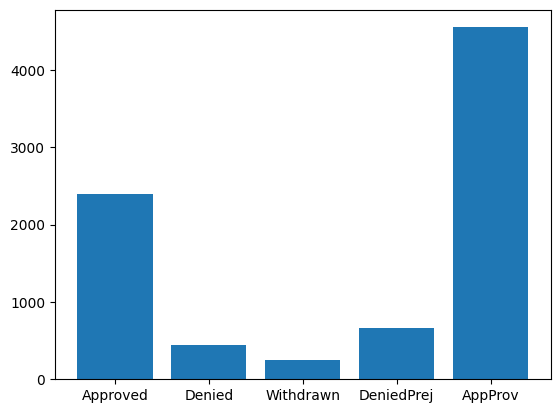

In [3]:
labels = [label for label in list(set(appeals_df['decision'])) if type(label) == str and label.strip() != '']
print(labels)
y_vals = [
    appeals_df[appeals_df['decision'] == label]['decision'].count() for label in labels
]

# Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
plt.bar(labels, y_vals)

In [4]:
denied_df = appeals_df.query('decision == "Denied" | decision == "DeniedPrej"')

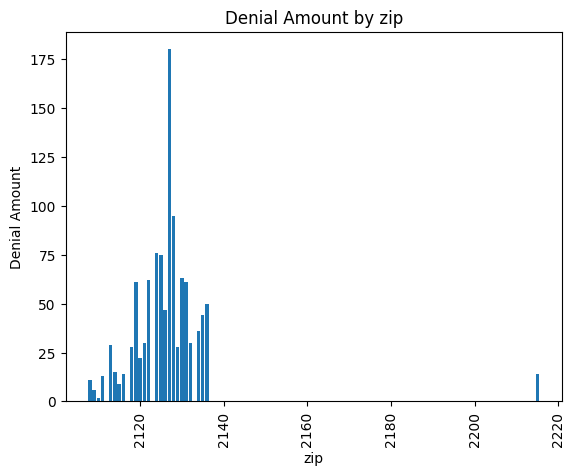

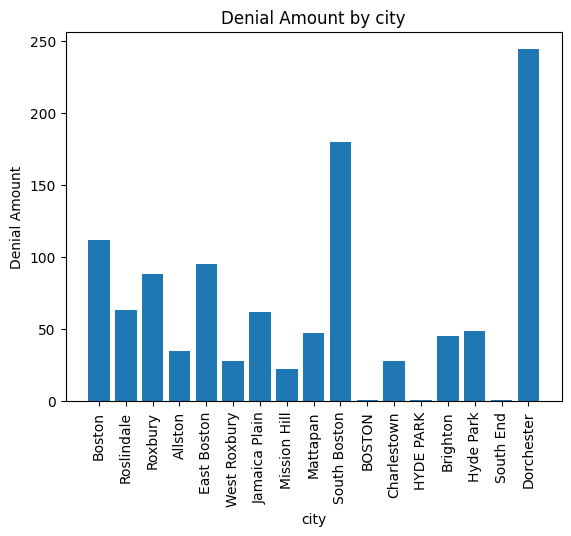

In [5]:
# Count zipcode, city, etc for denied permits

def count_labels(df, column_name):
    labels = [label for label in list(set(df[column_name]))]
    y_vals = [
        df[df[column_name] == label][column_name].count() for label in labels
    ]

    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Amount by {column_name}")
    plt.ylabel("Denial Amount")
    plt.xlabel(column_name)
    plt.bar(labels, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

count_labels(denied_df, "zip")
count_labels(denied_df, "city")

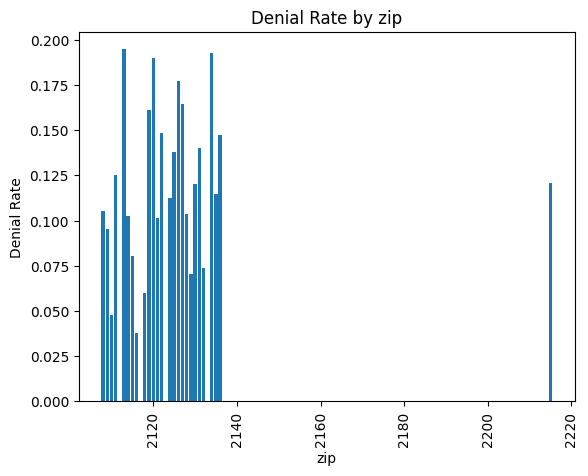

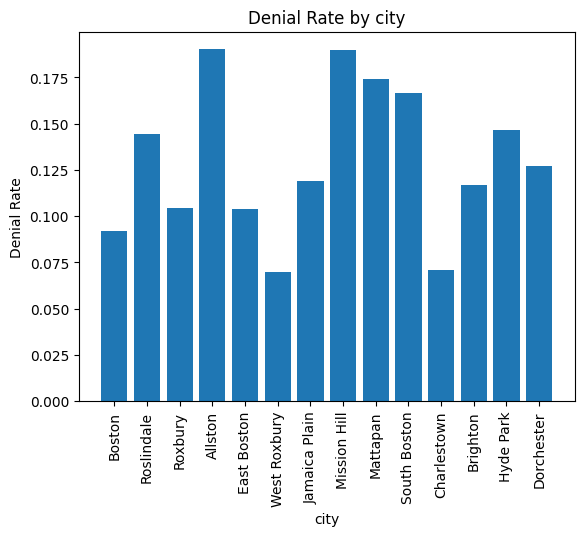

In [6]:
# Normalize by number of appeals in zip code

# Clean up city outliers
for city in list(set(denied_df['city'])):
    if len(denied_df[denied_df['city'] == city]) < 3:
        denied_df = denied_df[denied_df['city'] != city]
 
def count_labels_norm(df, column_name):
    labels = [label for label in list(set(df[column_name]))]
    y_vals = [
        ((df[df[column_name] == label][column_name].count()) / (appeals_df[appeals_df[column_name] == label].shape[0])) for label in labels
    ]

    # Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
    plt.title(f"Denial Rate by {column_name}")
    plt.ylabel("Denial Rate")
    plt.xlabel(column_name)
    plt.bar(labels, y_vals)
    plt.xticks(rotation = 90)
    plt.show()

count_labels_norm(denied_df, "zip")
count_labels_norm(denied_df, "city")

In [7]:
census_df = pd.read_csv('../data/redistricting_data_tract20_nbhd_hhpopsize_ab-1.csv')
voterdata_df = pd.read_csv('../data/VM2Uniform--MA--2021-01-19.tab', sep='\t', encoding='iso-8859-1', usecols=['Residence_Addresses_Zip', 'CommercialData_EstimatedHHIncomeAmount'])
voterdata_df.head()

,Residence_Addresses_Zip,CommercialData_EstimatedHHIncomeAmount
0,2638.0,$76957
1,2638.0,$76957
2,2638.0,$76957
3,2532.0,$118213
4,2563.0,NaN


In [8]:
zip_income_data = zip(voterdata_df['Residence_Addresses_Zip'], voterdata_df['CommercialData_EstimatedHHIncomeAmount'])

zip_to_mean_income = dict.fromkeys(voterdata_df['Residence_Addresses_Zip'], None)

for zipcode, income in zip_income_data:
    try:
        if zip_to_mean_income[zipcode] is None:
            zip_to_mean_income[zipcode] = []
        if type(income) == str:
            income = int(income[1:])
            zip_to_mean_income[zipcode].append(income)
    except:
        pass

for zipcode in zip_to_mean_income.keys():
    if zip_to_mean_income[zipcode] is not None:
        zip_to_mean_income[zipcode] = np.mean(zip_to_mean_income[zipcode])

/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/timevdo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


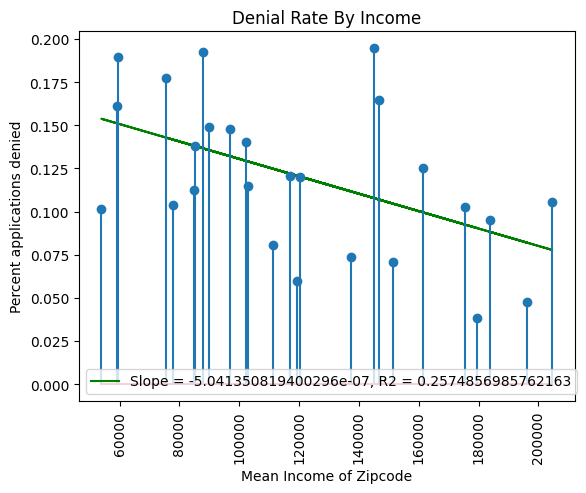

In [9]:
labels = [label for label in list(set(denied_df['zip']))]
y_vals = [
    ((denied_df[denied_df['zip'] == label]['zip'].count()) / (appeals_df[appeals_df['zip'] == label].shape[0])) for label in labels
]
x_vals = [zip_to_mean_income[int(label)] for label in labels]

a, b = np.polyfit(x_vals, y_vals, 1)
r2 = r2_score(y_vals, a*np.array(x_vals)+b)
plt.plot(x_vals, a*np.array(x_vals)+b, c='green', label=f'Slope = {a}, R2 = {r2}')
plt.legend()        

# Note: see that most appeals are approved, < 1000 are denied or denied with prejudice
plt.title("Denial Rate By Income")
plt.ylabel("Percent applications denied")
plt.xlabel("Mean Income of Zipcode")
plt.stem(x_vals, y_vals)
plt.xticks(rotation = 90)
plt.show()

In [10]:
bins = [list() for _ in range(7)]
bin_labels = ["< $80k", "$80-100k", "$100-120k", "$120-140k", "$140-160k", "$160-180k", "> 180k"]

for i, income in enumerate(x_vals):
    if income < 80_000:
        bins[0].append(y_vals[i])
    elif income < 100_000:
        bins[1].append(y_vals[i])
    elif income < 120_000:
        bins[2].append(y_vals[i])
    elif income < 140_000:
        bins[3].append(y_vals[i])
    elif income < 160_000:
        bins[4].append(y_vals[i])
    elif income < 180_000:
        bins[5].append(y_vals[i])
    else:
        bins[6].append(y_vals[i])

for i, bin in enumerate(bins):
    bins[i] = np.mean(bin)

In [11]:
gdp_df = pd.read_csv('../data/gdp_growth.tsv')
gdp_df = gdp_df[gdp_df['Year'] > 2012]

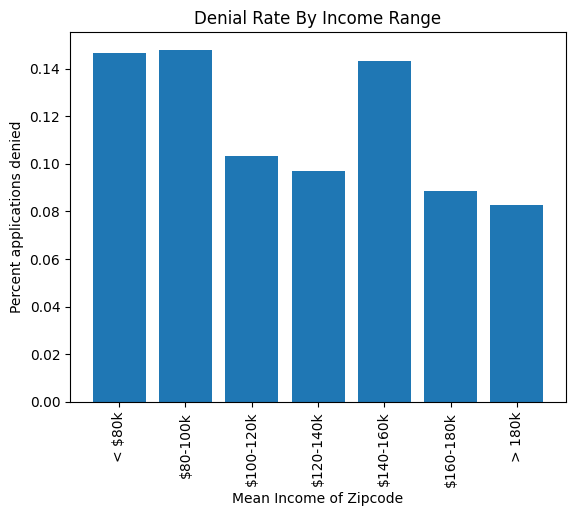

In [12]:
plt.title("Denial Rate By Income Range")
plt.ylabel("Percent applications denied")
plt.xlabel("Mean Income of Zipcode")
plt.bar(bin_labels, bins)
plt.xticks(rotation = 90)
plt.show()

In [13]:
np.mean(y_vals)

0.12029926841408141

In [14]:
# Find denial rate over time
appeals_df['submitted_year'] = pd.to_datetime(appeals_df['submitted_date']).dt.year
denied_df['submitted_year'] = pd.to_datetime(denied_df['submitted_date']).dt.year
appeals_df['submitted_month_year'] = pd.to_datetime(appeals_df['submitted_date']).dt.to_period('M')
denied_df['submitted_month_year'] = pd.to_datetime(denied_df['submitted_date']).dt.to_period('M')

/tmp/ipykernel_54951/2364623038.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


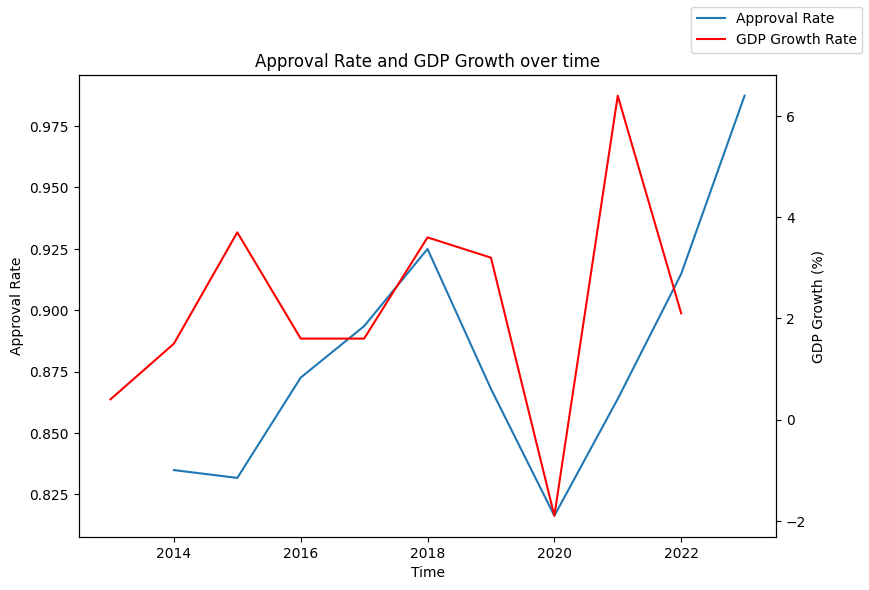

In [15]:
years = sorted([year for year in list(set(appeals_df['submitted_year']))])

x_vals = []
y_vals = []
for year in years[1:]:
    x_vals.append(year)
    y_vals.append(
        (appeals_df[appeals_df['submitted_year'] == year].shape[0] - denied_df[denied_df['submitted_year'] == year].shape[0]) / (appeals_df[appeals_df['submitted_year'] == year].shape[0])
    )

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx() 
ax1.plot(x_vals, y_vals, label='Approval Rate')
ax2.plot(gdp_df['Year'], gdp_df['GDP_Growth_Rate'], color='red', label='GDP Growth Rate')
fig.legend()
ax1.set_title('Approval Rate and GDP Growth over time')
ax1.set_xlabel("Time")
ax1.set_ylabel("Approval Rate")
ax2.set_ylabel("GDP Growth (%)")
fig.show()

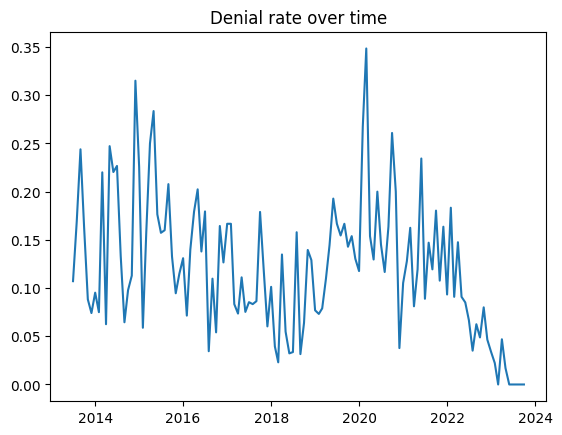

In [16]:
years = sorted([year for year in list(set(appeals_df['submitted_month_year']))])

x_vals = []
y_vals = []
for year in years[1:]:
    x_vals.append(year.to_timestamp())
    y_vals.append(
        (denied_df[denied_df['submitted_month_year'] == year].shape[0]) / (appeals_df[appeals_df['submitted_month_year'] == year].shape[0])
    )

plt.title("Denial rate over time")
plt.plot(x_vals, y_vals)
plt.show()

In [17]:
appeals_df['decision_year'] = pd.to_datetime(appeals_df['final_decision_date']).dt.year
denied_df['decision_year'] = pd.to_datetime(denied_df['final_decision_date']).dt.year
appeals_df['decision_month_year'] = pd.to_datetime(appeals_df['final_decision_date']).dt.to_period('M')
denied_df['decision_month_year'] = pd.to_datetime(denied_df['final_decision_date']).dt.to_period('M')

[2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0]


/tmp/ipykernel_54951/4273049698.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


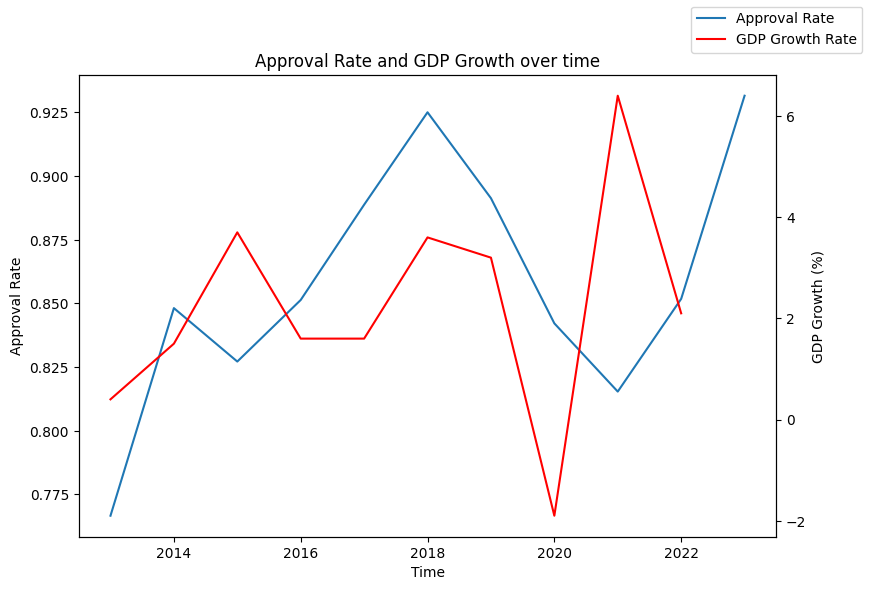

In [18]:
years = sorted([year for year in list(set(appeals_df['decision_year'].dropna()))])
print(years)

x_vals = []
y_vals = []
for year in years:
    x_vals.append(year)
    y_vals.append(
        (appeals_df[appeals_df['decision_year'] == year].shape[0] - denied_df[denied_df['decision_year'] == year].shape[0]) / (appeals_df[appeals_df['decision_year'] == year].shape[0])
    )

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx() 
ax1.plot(x_vals, y_vals, label='Approval Rate')
ax2.plot(gdp_df['Year'], gdp_df['GDP_Growth_Rate'], color='red', label='GDP Growth Rate')
fig.legend()
ax1.set_title('Approval Rate and GDP Growth over time')
ax1.set_xlabel("Time")
ax1.set_ylabel("Approval Rate")
ax2.set_ylabel("GDP Growth (%)")
fig.show()

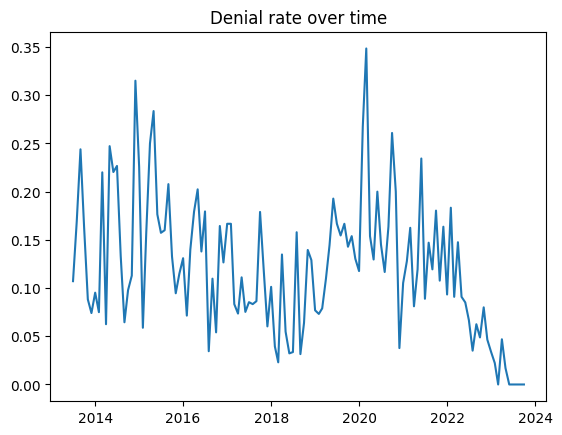

In [19]:
years = sorted([year for year in list(set(appeals_df['submitted_month_year'].dropna()))])

x_vals = []
y_vals = []
for year in years[1:]:
    x_vals.append(year.to_timestamp())
    y_vals.append(
        (denied_df[denied_df['submitted_month_year'] == year].shape[0]) / (appeals_df[appeals_df['submitted_month_year'] == year].shape[0])
    )

plt.title("Denial rate over time")
plt.plot(x_vals, y_vals)
plt.show()

In [25]:
import folium
import geopandas as gpd

from folium.plugins import MarkerCluster, HeatMap

boston_map_1 = folium.Map(location=[42.361145, -71.0589], zoom_start=13, control_scale=True)

from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase() 

zip_income_df = pd.DataFrame()
zip_income_df = appeals_df['zip']

zip_income_df['income'] = appeals_df['zip'].apply(lambda z : zip_to_mean_income[z])
zip_income_df['lat'] = appeals_df['zip'].apply(lambda z : zcdb[z].latitude)
zip_income_df['long'] = appeals_df['zip'].apply(lambda z : zcdb[z].longitude)

HeatMap(
    zip(zip_income_df['lat'], zip_income_df['long'], zip_income_df['income']),
    radius=50
).add_to(boston_map_1)

boston_map_1

/tmp/ipykernel_54951/2301621725.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income_df['income'] = appeals_df['zip'].apply(lambda z : zip_to_mean_income[z])
